# 实验7 卷积神经网络(CNN): 原理
本实验中你将使用Numpy实现卷积和池化层, 并用于前向/反向传播中
目标:
* 理解卷操作
* 应用两种不同类型的池化操作
* 认知CNN中的基本要素(如padding, stride, filter, ...) 及其功能目标
* 构建一个CNN

**符号**:
- 上标 $[l]$ 表示第$l}$层的一个对象, 例如: $a^{[4]}$ 是第 $4$ 层的激活函数输出. $W^{[5]}$ 和 $b^{[5]}$ 是第 $5$ 层的参数.
- 上标 $(i)$ 表示第$i$个样本, 例如: $x^{(i)}$ 是第 $i$ 个训练样本输入.
- 上标 $i$ 表示向量的第 $i$ 个元素, 例如: 在全连接层中, $a^{[l]}_i$ 表示第$l$层输出的第 $i$ 个元素.
- $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$ 分别表示第$l$层的高height, 宽width 和 通道数channels.
- $n_{H_{prev}}$, $n_{W_{prev}}$ 和 $n_{C_{prev}}$ 分别表示第前一层的高height, 宽width 和 通道数channels. 对于第$l$层来说, 也可以写作 $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$.

<a name='1'></a>
## 1 - 包

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from lib_public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

<a name='2'></a>
## 2 - 目录
你将一步步实现
- 卷积函数, 包括:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- 池化函数, 包括:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)

这些函数将被用于构建下图中的模型:
<img src="images/model.png" width=1000>

**注意**:
1. 对于每个前向传播函数都存在一个对应的反向传播函数. 因此, 需要将前向传播模块的输出参数保存在一个cache中. 这些参数将在反向传播中被用来计算梯度.
2. 本实验将使用`numpy`实现上述函数, 而下个实验将使用TF中已封装好的接口实现相同的操作.

<a name='3'></a>
## 3 - CNN
一个卷积层将输入数据转换为一个不同尺寸的输出数据, 如下图所示.

<img src="images/conv_nn.png" style="width:350px;height:200px;">

在这一部分中, 你将构建卷积层的每个步骤. 你将首先实现两个帮助函数: 一个作用于zero padding, 另一个作用于卷积函数计算本身.

<a name='3-1'></a>
### 3.1 - Zero-Padding

Zero-padding 在一个图片的边界四周添加0值:

<img src="images/PAD.png" width=1000>

Padding的主要作用在于:
- 改变数据尺寸因卷积操作而缩小的情况, 当输入输出尺寸保持不变时, 被称为 "same" convolution.
- 帮助维持图片边界信息.

<a name='ex-1'></a>
#### 练习 1 - zero_pad
实现下面的函数, 其功能是对给定的批样本X, 使用0值来扩充图片的边界.
*提示*:
[使用 np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). 如果你要对尺寸为$(5,5,5,5,5)$的数组"a"进行padding操作. 具体来说, 对维度下标为2和4的数据使用 `pad = 1` 和 `pad = 3`, 其余维度数据使用 `pad = 0`, 则相应的代码为:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```

In [6]:
"""
Function:
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image,
    as illustrated in Figure 1.
Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
"""
def zero_pad(X, pad):
    #(≈ 1 line)
    # X_pad = None
    # YOUR CODE STARTS HERE
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), mode='constant', constant_values = (0,0))
    # YOUR CODE ENDS HERE
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
 All tests passed.


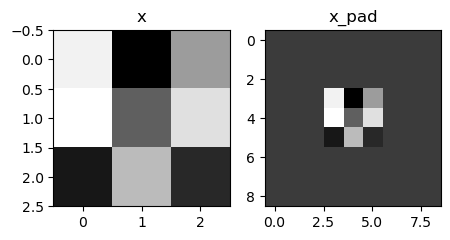

In [7]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

assert type(x_pad) == np.ndarray, "Output must be a np array"
assert x_pad.shape == (4, 9, 9, 2), f"Wrong shape: {x_pad.shape} != (4, 9, 9, 2)"
print(x_pad[0, 0:2,:, 0])
assert np.allclose(x_pad[0, 0:2,:, 0], [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Rows are not padded with zeros"
assert np.allclose(x_pad[0, :, 7:9, 1].transpose(), [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 1e-15), "Columns are not padded with zeros"
assert np.allclose(x_pad[:, 3:6, 3:6, :], x, 1e-15), "Internal values are different"

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])
zero_pad_test(zero_pad)

<a name='3-2'></a>
### 3.2 - 卷积操作

具体步骤如下:
- 获取输入数据
- 在输入数据的每个位置应用滤波器/卷积核
- 输出数据

<img src="images/Convolution_schematic.gif" width=500>

在计算机视觉应用中, 一幅图像可以表示为图中左边所示的矩阵, 矩阵中的每个值对应于一个像素值.
使用一个3x3的滤波器对图像进行卷积, 意味着将该滤波器与矩阵中的对应值逐元素相乘然后求和, 并加上一个偏置.

在练习2中, 你将实现卷积中的一小步操作, 即对于给定位置应用滤波器, 得到一个输出结果.
后续你将在多个位置使用该函数, 以实现完整的卷积操作.

<a name='ex-2'></a>
#### 练习 2 - conv_single_step
实现函数 `conv_single_step()`.

**注意**:
函数参数b是一个Numpy数组变量, 如果你将其与一个标量(即一个浮点数或整数)进行相加, 结果仍然是一个Numpy数组.
*提示*:
如果某Numpy数组$x$仅有一个值, 你可以使用float(x)对其进行强制类型转换为一个浮点数标量.

In [8]:
"""
Function:
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation
    of the previous layer.
Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
"""
def conv_single_step(a_slice_prev, W, b):
    #(≈ 3 lines of code)
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    # s = None
    # Sum over all entries of the volume s.
    # Z = None
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    # Z = None
    # YOUR CODE STARTS HERE
    s = a_slice_prev * W
    Z = np.sum(s)
    Z = np.float64(b + Z)
    # YOUR CODE ENDS HERE
    return Z

In [9]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)
conv_single_step_test(conv_single_step)

assert (type(Z) == np.float64 or type(Z) == np.float32), "You must cast the output to float"
assert np.isclose(Z, -6.999089450680221), "Wrong value"

Z = -6.999089450680221
 All tests passed.


<a name='3-3'></a>
### 3.3 - CNN - 前向传播
在前向传播中, 你将使用多个滤波器并将其与输入数据进行卷积. 每个滤波器卷积的结果是一个二维数据. 最终需要将所有的2D数据叠加成为3D数据进行输出:

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

<a name='ex-3'></a>
#### 练习 3 -  conv_forward
实现下面的函数, 其输入包含:
* `A_prev`, 前一层激活函数的输出(m个样本中的一个批次数据);
* `W`, 权值, 即尺寸为$f \times f$的滤波器上的值.
* `b`, 偏置向量, 每个滤波器对应一个偏置.

你需要访问超参数字典来获取步长 stride 和 padding值.

**提示**:
1. 若要在一个矩阵"a_prev" (尺寸为 (5,5,3))上选择其左上角一个 2x2 的区域, 可使用如下的代码:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
注意, "a_slice_prev"是一个三维体数据, 其高、款、深度（即通道数）分别为 2, 2 和 3.

2. 参考上述切片方法可以得到下面练习代码中的`a_slice_prev`，具体来说，需要确定垂直和水平方向上的起止索引 `vert_start`, `vert_end`, `horiz_start` 和 `horiz_end`（见下图）. 它们可以通过代码中的变量 h, w, f 和 stride 计算得到。

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">

3. 下面的公式为计算卷积输出数据尺寸的方法:
$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \Bigr\rfloor +1$$
$$n_C = \text{number of filters used in the convolution}$$
    
本练习中将不采样向量化方法，而是使用for循环来实现

#### Additional Hints (if you're stuck):


* Use array slicing (e.g.`varname[0:1,:,3:5]`) for the following variables:  
  `a_prev_pad` ,`W`, `b`  
  - Copy the starter code of the function and run it outside of the defined function, in separate cells.  
  - Check that the subset of each array is the size and dimension that you're expecting.  
* To decide how to get the `vert_start`, `vert_end`, `horiz_start`, `horiz_end`, remember that these are indices of the previous layer.  
  - Draw an example of a previous padded layer (8 x 8, for instance), and the current (output layer) (2 x 2, for instance).  
  - The output layer's indices are denoted by `h` and `w`.  
* Make sure that `a_slice_prev` has a height, width and depth.
* Remember that `a_prev_pad` is a subset of `A_prev_pad`.  
  - Think about which one should be used within the for loops.

In [10]:
"""
Function:
    Implements the forward propagation for a convolution function
Arguments:
    A_prev -- output activations of the previous layer,
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
"""
def conv_forward(A_prev, W, b, hparameters):
    # Retrieve dimensions from A_prev's shape (≈1 line)  
    # (m, n_H_prev, n_W_prev, n_C_prev) = None
    # YOUR CODE STARTS HERE
    (m, n_H_prev, n_W_prev, n_C_prev) = np.shape(A_prev)
    # YOUR CODE ENDS HERE
    
    # Retrieve dimensions from W's shape (≈1 line)
    # (f, f, n_C_prev, n_C) = None
    # YOUR CODE STARTS HERE
    (f, f, n_C_prev, n_C) = np.shape(W)
    # YOUR CODE ENDS HERE
    
    # Retrieve information from "hparameters" (≈2 lines)
    # stride = None
    # pad = None
    # YOUR CODE STARTS HERE
    stride = hparameters['stride']
    pad = hparameters['pad']
    # YOUR CODE ENDS HERE
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. (≈2 lines)
    # n_H = None
    # n_W = None
    # YOUR CODE STARTS HERE
    n_H = int((n_H_prev - f + 2 * pad) / stride) + 1
    n_W = int((n_W_prev - f + 2 * pad) / stride) + 1
    # YOUR CODE ENDS HERE
    
    # Initialize the output volume Z with zeros. (≈1 line)
    # Z = None
    # YOUR CODE STARTS HERE
    Z = np.zeros((m, n_H, n_W, n_C))
    # YOUR CODE ENDS HERE
    
    # Create A_prev_pad by padding A_prev
    # A_prev_pad = None
    # YOUR CODE STARTS HERE
    A_prev_pad = zero_pad(A_prev, pad)
    # YOUR CODE ENDS HERE

    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]     # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            # vert_start = ...
            # vert_end = ...
            # YOUR CODE STARTS HERE
            vert_start = h * stride
            vert_end = h * stride+ f
            # YOUR CODE ENDS HERE
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice" (≈2 lines)
                # horiz_start = ...
                # horiz_end = ...
                # YOUR CODE STARTS HERE
                horiz_start = w * stride
                horiz_end = w * stride + f
                # YOUR CODE ENDS HERE
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    # a_slice_prev = ...
                    # YOUR CODE STARTS HERE
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    # YOUR CODE ENDS HERE

                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    # weights = ...
                    # biases = ...
                    # Z[i, h, w, c] = ...
                    # YOUR CODE STARTS HERE
                    weights = W[:, :, :, c]
                    biases  = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev,W[:,:,:,c], b[:,:,:,c])
                    # YOUR CODE ENDS HERE

    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [11]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[0,2,1] =\n", Z[0, 2, 1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

conv_forward_test(conv_forward)


Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]
(2, 13, 15, 8)
 All tests passed.


最后, 一个卷积层需要包含一个激活函数, 可通过下面的代码实现:

```python
# Convolve the window to get back one output neuron
Z[i, h, w, c] = ...
# Apply activation
A[i, h, w, c] = activation(Z[i, h, w, c])
```
但你并不需要在此处实现

<a name='4'></a>
## 4 - 池化层

池化 (POOL) 层将缩减输入的宽和高以减低计算量，并确保特征具备位置不变性. 有下面两类池化层:

- Max-pooling layer: slides an ($f, f$) window over the input and stores the max value of the window in the output.
- Average-pooling layer: slides an ($f, f$) window over the input and stores the average value of the window in the output.

<table>
    <td>
        <img src="images/max_pool1.png" width=600>
    <td>
    <td>
        <img src="images/a_pool.png" width=600>
    <td>
</table>

这些池化层没有参数需要更新，但具有窗口尺寸 $f$ 等超参数.

<a name='4-1'></a>
### 4.1 - 前向池化
接下来你将在同一个函数中实现 MAX-POOL 和 AVG-POOL

<a name='ex-4'></a>
#### 练习 4 - pool_forward

**提示**:
由于没有padding, 输出数据尺寸公式可以重写为:

$$n_H = \Bigl\lfloor \frac{n_{H_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_W = \Bigl\lfloor \frac{n_{W_{prev}} - f}{stride} \Bigr\rfloor +1$$

$$n_C = n_{C_{prev}}$$

In [25]:
"""
Function:
    Implements the forward pass of the pooling layer
Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters
"""
def pool_forward(A_prev, hparameters, mode = "max"):
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            # vert_start = ...
            # vert_end = ...
            # YOUR CODE STARTS HERE
            vert_start = stride * h 
            vert_end = vert_start + f
            # YOUR CODE ENDS HERE
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                # horiz_start = ...
                # horiz_end = ...
                # YOUR CODE STARTS HERE
                horiz_start = stride * w
                horiz_end = horiz_start + f
                # YOUR CODE ENDS HERE
                for c in range (n_C):            # loop over the channels of the output volume
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    # a_prev_slice = None
                    # YOUR CODE STARTS HERE
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end,c]
                    # YOUR CODE ENDS HERE

                    # Compute the pooling operation on the slice.
                    # Use an if statement to differentiate the modes.
                    # Use np.max and np.mean.
                    # if mode == "max":
                        # A[i, h, w, c] = None
                    # elif mode == "average":
                        # A[i, h, w, c] = None
                    # YOUR CODE STARTS HERE
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
                    else:
                        print(mode+ "-type pooling layer NOT Defined")    
                    # YOUR CODE ENDS HERE
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    #assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [26]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

pool_forward_test(pool_forward)

mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]

mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]
 All tests passed.


In [27]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])

mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


**Expected Output:**
    
```
mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]
```

<font color='blue'>
    
**What you should remember**:

* A convolution extracts features from an input image by taking the dot product between the input data and a 2D array of weights (the filter). 
* The 2D output of the convolution is called the feature map
* A convolution layer is where the filter slides over the image and computes the dot product 
    * This transforms the input volume into an output volume of different size 
* Zero padding helps keep more information at the image borders, and is helpful for building deeper networks, because you can build a CONV layer without shrinking the height and width of the volumes
* Pooling layers gradually reduce the height and width of the input by sliding a 2D window over each specified region, then summarizing the features in that region

**Congratulations**! You have now implemented the forward passes of all the layers of a convolutional network. Great work!

The remainder of this notebook is optional, and will not be graded. If you carry on, just remember to hit the Submit button to submit your work for grading first. 

<a name='5'></a>
## 5 - Backpropagation in Convolutional Neural Networks (OPTIONAL / UNGRADED)

In modern deep learning frameworks, you only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with the details of the backward pass. The backward pass for convolutional networks is complicated. If you wish, you can work through this optional portion of the notebook to get a sense of what backprop in a convolutional network looks like. 

When in an earlier course you implemented a simple (fully connected) neural network, you used backpropagation to compute the derivatives with respect to the cost to update the parameters. Similarly, in convolutional neural networks you can calculate the derivatives with respect to the cost in order to update the parameters. The backprop equations are not trivial and were not derived in lecture, but  are briefly presented below.

<a name='5-1'></a>
### 5.1 - Convolutional Layer Backward Pass 

Let's start by implementing the backward pass for a CONV layer. 

<a name='5-1-1'></a>
#### 5.1.1 - Computing dA:
This is the formula for computing $dA$ with respect to the cost for a certain filter $W_c$ and a given training example:

$$dA \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^{n_W} W_c \times dZ_{hw} \tag{1}$$

Where $W_c$ is a filter and $dZ_{hw}$ is a scalar corresponding to the gradient of the cost with respect to the output of the conv layer Z at the hth row and wth column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time, you multiply the the same filter $W_c$ by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, you are just adding the gradients of all the a_slices. 

In code, inside the appropriate for-loops, this formula translates into:
```python
da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
```

<a name='5-1-2'></a>
#### 5.1.2 - Computing dW:
This is the formula for computing $dW_c$ ($dW_c$ is the derivative of one filter) with respect to the loss:

$$dW_c  \mathrel{+}= \sum _{h=0} ^{n_H} \sum_{w=0} ^ {n_W} a_{slice} \times dZ_{hw}  \tag{2}$$

Where $a_{slice}$ corresponds to the slice which was used to generate the activation $Z_{ij}$. Hence, this ends up giving us the gradient for $W$ with respect to that slice. Since it is the same $W$, we will just add up all such gradients to get $dW$. 

In code, inside the appropriate for-loops, this formula translates into:
```python
dW[:,:,:,c] \mathrel{+}= a_slice * dZ[i, h, w, c]
```

<a name='5-1-3'></a>
#### 5.1.3 - Computing db:

This is the formula for computing $db$ with respect to the cost for a certain filter $W_c$:

$$db = \sum_h \sum_w dZ_{hw} \tag{3}$$

As you have previously seen in basic neural networks, db is computed by summing $dZ$. In this case, you are just summing over all the gradients of the conv output (Z) with respect to the cost. 

In code, inside the appropriate for-loops, this formula translates into:
```python
db[:,:,:,c] += dZ[i, h, w, c]
```

<a name='ex-5'></a>
### Exercise 5 - conv_backward

Implement the `conv_backward` function below. You should sum over all the training examples, filters, heights, and widths. You should then compute the derivatives using formulas 1, 2 and 3 above. 

In [32]:
def conv_backward(dZ, cache):
    """
    Implement the backward propagation for a convolution function
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward(), output of conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """    
    
        
    # Retrieve information from "cache"
    # (A_prev, W, b, hparameters) = None
    # Retrieve dimensions from A_prev's shape
    # (m, n_H_prev, n_W_prev, n_C_prev) = None
    # Retrieve dimensions from W's shape
    # (f, f, n_C_prev, n_C) = None
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    # Retrieve information from "hparameters"
    # stride = None
    # pad = None
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    # Retrieve dimensions from dZ's shape
    # (m, n_H, n_W, n_C) = None
    (m, n_H, n_W, n_C) = dZ.shape
    # Initialize dA_prev, dW, db with the correct shapes
    # dA_prev = None                          
    # dW = None
    # db = None
    dA_prev = np.zeros(A_prev.shape)                          
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape) # b.shape = [1,1,1,n_C]
    # Pad A_prev and dA_prev
    # A_prev_pad = zero_pad(A_prev, pad)
    # dA_prev_pad = zero_pad(dA_prev, pad)
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    for i in range(m):                       # loop over the training examples
        
        # select ith training example from A_prev_pad and dA_prev_pad
        # a_prev_pad = None
        # da_prev_pad = None
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        for h in range(n_H):                   # loop over vertical axis of the output volume
           for w in range(n_W):               # loop over horizontal axis of the output volume
               for c in range(n_C):           # loop over the channels of the output volume
                    
                    # Find the corners of the current "slice"
                    # vert_start = None
                    # vert_end = None
                    # horiz_start = None
                    # horiz_end = None
                    vert_start = stride * h 
                    vert_end = vert_start + f
                    horiz_start = stride * w
                    horiz_end = horiz_start + f
                    # Use the corners to define the slice from a_prev_pad
                    # a_slice = None
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    # da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += None
                    # dW[:,:,:,c] += None
                    # db[:,:,:,c] += None
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
        # Set the ith training example's dA_prev to the unpadded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        # dA_prev[i, :, :, :] = None
    # YOUR CODE STARTS HERE
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]
    
    # YOUR CODE ENDS HERE
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [33]:
# We'll run conv_forward to initialize the 'Z' and 'cache_conv",
# which we'll use to test the conv_backward function
np.random.seed(1)
A_prev = np.random.randn(10, 4, 4, 3)
W = np.random.randn(2, 2, 3, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 2,
               "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

# Test conv_backward
dA, dW, db = conv_backward(Z, cache_conv)

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

assert type(dA) == np.ndarray, "Output must be a np.ndarray"
assert type(dW) == np.ndarray, "Output must be a np.ndarray"
assert type(db) == np.ndarray, "Output must be a np.ndarray"
assert dA.shape == (10, 4, 4, 3), f"Wrong shape for dA  {dA.shape} != (10, 4, 4, 3)"
assert dW.shape == (2, 2, 3, 8), f"Wrong shape for dW {dW.shape} != (2, 2, 3, 8)"
assert db.shape == (1, 1, 1, 8), f"Wrong shape for db {db.shape} != (1, 1, 1, 8)"
assert np.isclose(np.mean(dA), 1.4524377), "Wrong values for dA"
assert np.isclose(np.mean(dW), 1.7269914), "Wrong values for dW"
assert np.isclose(np.mean(db), 7.8392325), "Wrong values for db"

print("\033[92m All tests passed.")

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838
 All tests passed.


**Expected Output**:
<table>
    <tr>
        <td>
            dA_mean
        </td>
        <td>
            1.45243777754
        </td>
    </tr>
    <tr>
        <td>
            dW_mean
        </td>
        <td>
            1.72699145831
        </td>
    </tr>
    <tr>
        <td>
            db_mean
        </td>
        <td>
            7.83923256462
        </td>
    </tr>

</table>


<a name='5-2'></a>
## 5.2 Pooling Layer - Backward Pass

Next, let's implement the backward pass for the pooling layer, starting with the MAX-POOL layer. Even though a pooling layer has no parameters for backprop to update, you still need to backpropagate the gradient through the pooling layer in order to compute gradients for layers that came before the pooling layer. 

<a name='5-2-1'></a>
### 5.2.1 Max Pooling - Backward Pass  

Before jumping into the backpropagation of the pooling layer, you are going to build a helper function called `create_mask_from_window()` which does the following: 

$$ X = \begin{bmatrix}
1 && 3 \\
4 && 2
\end{bmatrix} \quad \rightarrow  \quad M =\begin{bmatrix}
0 && 0 \\
1 && 0
\end{bmatrix}\tag{4}$$

As you can see, this function creates a "mask" matrix which keeps track of where the maximum of the matrix is. True (1) indicates the position of the maximum in X, the other entries are False (0). You'll see later that the backward pass for average pooling is similar to this, but uses a different mask.  

<a name='ex-6'></a>
### Exercise 6 - create_mask_from_window

Implement `create_mask_from_window()`. This function will be helpful for pooling backward. 
Hints:
- [np.max()]() may be helpful. It computes the maximum of an array.
- If you have a matrix X and a scalar x: `A = (X == x)` will return a matrix A of the same size as X such that:
```
A[i,j] = True if X[i,j] = x
A[i,j] = False if X[i,j] != x
```
- Here, you don't need to consider cases where there are several maxima in a matrix.

In [35]:
def create_mask_from_window(x):
    """
    Creates a mask from an input matrix x, to identify the max entry of x.
    
    Arguments:
    x -- Array of shape (f, f)
    
    Returns:
    mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x.
    """    
    # (≈1 line)
    # mask = None
    # YOUR CODE STARTS HERE
    mask = (x == np.max(x))
    # YOUR CODE ENDS HERE
    return mask

In [36]:
np.random.seed(1)
x = np.random.randn(2, 3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x = np.array([[-1, 2, 3],
              [2, -3, 2],
              [1, 5, -2]])

y = np.array([[False, False, False],
     [False, False, False],
     [False, True, False]])
mask = create_mask_from_window(x)
assert type(mask) == np.ndarray, "Output must be a np.ndarray"
assert mask.shape == x.shape, "Input and output shapes must match"
assert np.allclose(mask, y), "Wrong output. The True value must be at position (2, 1)"

print("\033[92m All tests passed.")

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]
 All tests passed.


**Expected Output:** 

<table> 
<tr> 
<td>

**x =**
</td>

<td>

[[ 1.62434536 -0.61175641 -0.52817175] <br>
 [-1.07296862  0.86540763 -2.3015387 ]]

  </td>
</tr>

<tr> 
<td>
mask =
</td>
<td>
[[ True False False] <br>
 [False False False]]
</td>
</tr>


</table>

Why keep track of the position of the max? It's because this is the input value that ultimately influenced the output, and therefore the cost. Backprop is computing gradients with respect to the cost, so anything that influences the ultimate cost should have a non-zero gradient. So, backprop will "propagate" the gradient back to this particular input value that had influenced the cost. 

<a name='5-2-2'></a>
### 5.2.2 - Average Pooling - Backward Pass 

In max pooling, for each input window, all the "influence" on the output came from a single input value--the max. In average pooling, every element of the input window has equal influence on the output. So to implement backprop, you will now implement a helper function that reflects this.

For example if we did average pooling in the forward pass using a 2x2 filter, then the mask you'll use for the backward pass will look like: 
$$ dZ = 1 \quad \rightarrow  \quad dZ =\begin{bmatrix}
1/4 && 1/4 \\
1/4 && 1/4
\end{bmatrix}\tag{5}$$

This implies that each position in the $dZ$ matrix contributes equally to output because in the forward pass, we took an average. 

<a name='ex-7'></a>
### Exercise 7 - distribute_value

Implement the function below to equally distribute a value dz through a matrix of dimension shape. 

[Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ones.html)

In [37]:
def distribute_value(dz, shape):
    """
    Distributes the input value in the matrix of dimension shape
    
    Arguments:
    dz -- input scalar
    shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
    a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """    
    # Retrieve dimensions from shape (≈1 line)
    # (n_H, n_W) = None
    (n_H, n_W) = shape
    # Compute the value to distribute on the matrix (≈1 line)
    # average = None
    average = np.prod(shape)
    # Create a matrix where every entry is the "average" value (≈1 line)
    # a = None
    # YOUR CODE STARTS HERE
    a = (dz/average)*np.ones(shape)
    
    # YOUR CODE ENDS HERE
    return a

In [38]:
a = distribute_value(2, (2, 2))
print('distributed value =', a)


assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (2, 2), f"Wrong shape {a.shape} != (2, 2)"
assert np.sum(a) == 2, "Values must sum to 2"

a = distribute_value(100, (10, 10))
assert type(a) == np.ndarray, "Output must be a np.ndarray"
assert a.shape == (10, 10), f"Wrong shape {a.shape} != (10, 10)"
assert np.sum(a) == 100, "Values must sum to 100"

print("\033[92m All tests passed.")

distributed value = [[0.5 0.5]
 [0.5 0.5]]
 All tests passed.


**Expected Output**: 

<table> 
<tr> 
<td>
distributed_value =
</td>
<td>
[[ 0.5  0.5]
<br\> 
[ 0.5  0.5]]
</td>
</tr>
</table>

<a name='5-2-3'></a>
### 5.2.3 Putting it Together: Pooling Backward 

You now have everything you need to compute backward propagation on a pooling layer.

<a name='ex-8'></a>
### Exercise 8 - pool_backward

Implement the `pool_backward` function in both modes (`"max"` and `"average"`). You will once again use 4 for-loops (iterating over training examples, height, width, and channels). You should use an `if/elif` statement to see if the mode is equal to `'max'` or `'average'`. If it is equal to 'average' you should use the `distribute_value()` function you implemented above to create a matrix of the same shape as `a_slice`. Otherwise, the mode is equal to '`max`', and you will create a mask with `create_mask_from_window()` and multiply it by the corresponding value of dA.

In [41]:
def pool_backward(dA, cache, mode = "max"):
    """
    Implements the backward pass of the pooling layer
    
    Arguments:
    dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
    cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters 
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    # Retrieve information from cache (≈1 line)
    # (A_prev, hparameters) = None
    (A_prev, hparameters) = cache
    # Retrieve hyperparameters from "hparameters" (≈2 lines)
    # stride = None
    # f = None
    stride = hparameters["stride"]
    f = hparameters["f"]
    # Retrieve dimensions from A_prev's shape and dA's shape (≈2 lines)
    # m, n_H_prev, n_W_prev, n_C_prev = None
    # m, n_H, n_W, n_C = None
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    # Initialize dA_prev with zeros (≈1 line)
    # dA_prev = None
    dA_prev = np.zeros(A_prev.shape)
    for i in range(m): # loop over the training examples
        
        # select training example from A_prev (≈1 line)
        # a_prev = None
        a_prev = A_prev[i,:,:,:]
        for h in range(n_H):                   # loop on the vertical axis
            for w in range(n_W):               # loop on the horizontal axis
                for c in range(n_C):           # loop over the channels (depth)
        
                    # Find the corners of the current "slice" (≈4 lines)
                    # vert_start = None
                    # vert_end = None
                    # horiz_start = None
                    # horiz_end = None
                    vert_start  = h * stride
                    vert_end    = h * stride + f
                    horiz_start = w * stride
                    horiz_end   = w * stride + f
                    # Compute the backward propagation in both modes.
                    if mode == "max":
                        
                        # Use the corners and "c" to define the current slice from a_prev (≈1 line)
                        # a_prev_slice = None
                        a_prev_slice = a_prev[ vert_start:vert_end, horiz_start:horiz_end, c ]
                        # Create the mask from a_prev_slice (≈1 line)
                        # mask = None
                        mask = create_mask_from_window( a_prev_slice )
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA) (≈1 line)
                        # dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += None
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += mask * dA[i, h, w, c]
                    elif mode == "average":
                        
                        # Get the value da from dA (≈1 line)
                        # da = None
                        da = dA[i, h, w, c]
                        # Define the shape of the filter as fxf (≈1 line)
                        # shape = None
                        shape = (f,f)
                        # Distribute it to get the correct slice of dA_prev. i.e. Add the distributed value of da. (≈1 line)
                        # dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += None
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    
    # Making sure your output shape is correct
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [42]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
print(A.shape)
print(cache[0].shape)
dA = np.random.randn(5, 4, 2, 2)

dA_prev1 = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev1[1,1] = ', dA_prev1[1, 1])  
print()
dA_prev2 = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev2[1,1] = ', dA_prev2[1, 1]) 

assert type(dA_prev1) == np.ndarray, "Wrong type"
assert dA_prev1.shape == (5, 5, 3, 2), f"Wrong shape {dA_prev1.shape} != (5, 5, 3, 2)"
assert np.allclose(dA_prev1[1, 1], [[0, 0], 
                                    [ 5.05844394, -1.68282702],
                                    [ 0, 0]]), "Wrong values for mode max"
assert np.allclose(dA_prev2[1, 1], [[0.08485462,  0.2787552], 
                                    [1.26461098, -0.25749373], 
                                    [1.17975636, -0.53624893]]), "Wrong values for mode average"
print("\033[92m All tests passed.")

(5, 4, 2, 2)
(5, 5, 3, 2)
mode = max
mean of dA =  0.14571390272918056
dA_prev1[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev2[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
 All tests passed.


**Expected Output**: 

mode = max:
<table> 
<tr> 
<td>

**mean of dA =**
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
dA_prev[1,1] =
</td>
<td>
[[ 0.          0.        ] <br>
 [ 5.05844394 -1.68282702] <br>
 [ 0.          0.        ]]
</td>
</tr>
</table>

mode = average
<table> 
<tr> 
<td>

mean of dA =
</td>

<td>

0.145713902729

  </td>
</tr>

<tr> 
<td>
dA_prev[1,1] =
</td>
<td>
[[ 0.08485462  0.2787552 ] <br>
 [ 1.26461098 -0.25749373] <br>
 [ 1.17975636 -0.53624893]]
</td>
</tr>
</table>

**Congratulations**! You've completed the assignment and its optional portion. You now understand how convolutional neural networks work, and have implemented all the building blocks of a neural network. In the next assignment you will implement a ConvNet using TensorFlow. Nicely done! See you there.